## Get reference velocity 

GOAL: reference velocity is not saved and, because of the LabGraph timing errors, a simple diff on reference position does not get you the velocity. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn
import scipy
from scipy.optimize import minimize,least_squares
import copy as copy
import time as tpy
import glob
import os
import pandas as pd
import pickle
from scipy.stats import wilcoxon as wilcoxon
import scipy.signal as sig


# seaborn.set()

In [2]:
# path = '/Volumes/My Passport/cphs'
path = '/Users/mmadduri/OneDrive - UW/PhD_Research/Data/continuous-full'

with open(path + '/continuous_full_data_block1.pickle', 'rb') as handle:
    refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112', 'METACPHS_S113', 'METACPHS_S114', 'METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']

with open(path + '/continuous_full_data_block2.pickle', 'rb') as handle:
    refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
# keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112']
keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112', 'METACPHS_S113', 'METACPHS_S114', 'METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']


In [3]:
def samsmooth( t_, t, y, T ):
    y_ = []
    for _t in t_:
        i = np.nonzero( (t >= _t - T/2) * (t <= _t + T/2) )[0]
        if i.size == 0:
            y_.append(y_[-1])
        else:
            y_.append( y[i].mean() )
    
    return np.asarray(y_) 

from scipy.signal import butter,filtfilt

def samdiff( t_, y_, N, Wn, fs ):
    dt = np.median(np.diff(t_))
    assert np.allclose( dt, np.diff(t_) )
    b, a = butter( N, Wn, fs=fs )
    y__ = filtfilt( b, a, y_ )
    dy__ = np.diff( y__ ) / dt
    dy_ = filtfilt( b, a, dy__ )
    return dy_

In [8]:
ref = refs_block1[keys[0]][0, :, :]
ref.shape

time_x = times_block1[keys[0]][0]


(20770,)

In [51]:
def diff_vel_from_ref(ref, time, dim = 2, dtx = 1/60):
    # the velocity that will be interpolated
    vel = np.zeros_like(ref)
    # rearrange the time data so it's evenly sampled for the fft calculations
    tnew = np.arange(np.min(time), np.max(time), dtx)
    
    # for each access
    for ax in range(dim):
        ref_ = ref[:, ax]

        # resample the reference with the evenly sampled time
        rnew = samsmooth(tnew, time, ref_, 0.1) # smooth and evenly spaced

        # take the diff that converts refernce to the velocity
        vnew = samdiff(tnew, rnew, 2, 2, 1/dtx)
    
        # reinterpolate the function back to labgraph time
        # bounds_error = False -- set to false so out-of-bounds elements (i.e. first and last) are assigned to fill value
        # fill value is extrapolated
        f = scipy.interpolate.interp1d(tnew[1:], vnew, bounds_error = False, fill_value='extrapolate') 
        vsamp = f(time[1:])

        # convert nans to 0 -- first and last 

        vel[1:, ax] = vsamp

        # convert nans to 0s
        

    return vel

This is how the samsmooth and samdiff is used -- written into a function and confirming that both x and y axes work

1.3867242080000324


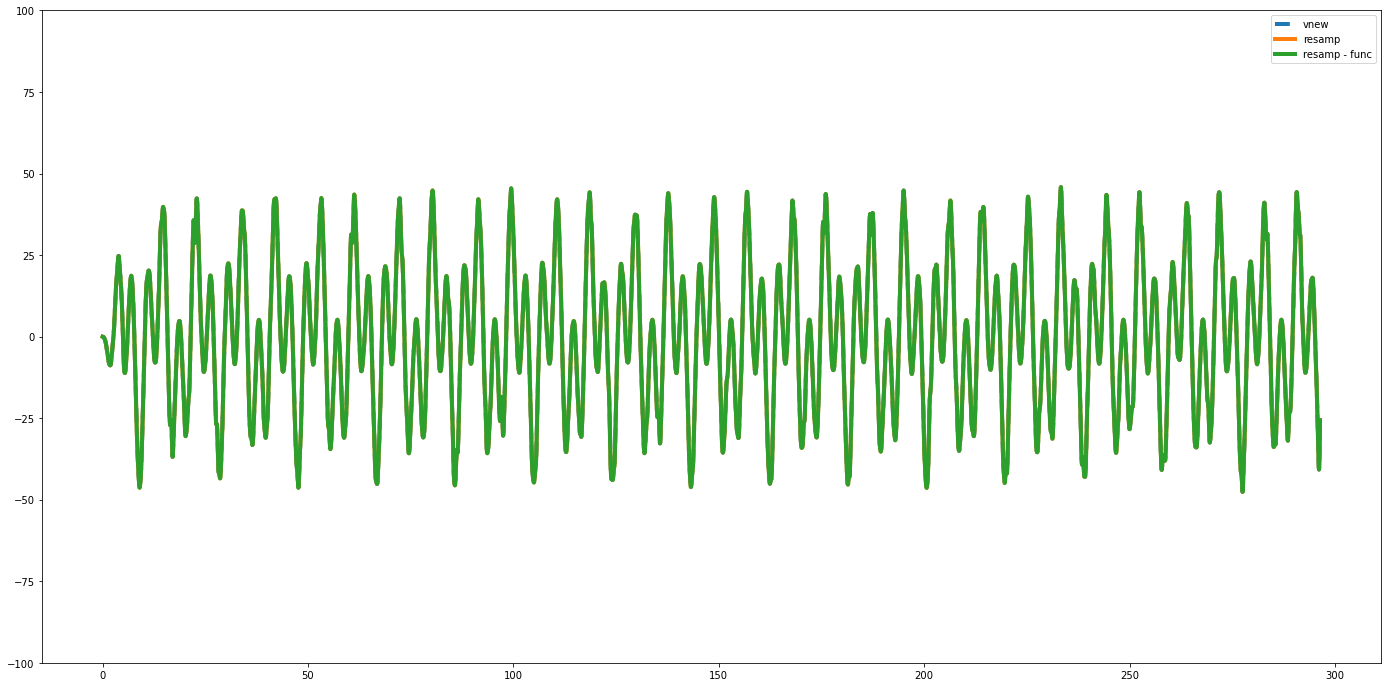

<Figure size 1728x864 with 0 Axes>

In [65]:
from timeit import default_timer as timer

# raw
# samsmooth - unf spaced samples and slightly smoother signal
# derivative of samdiff --> butterworth filter, apply filtfilt --> take diff and apply filtfilt to result
# reinterpolate that function to back to labgraph time 

refx = ref[:, 0]
tx = time_x
dec_vel = dec_vels_block1[keys[0]][0, :, 0]
dtx = 1/60
# rearrange the time data so it's evenly sampled for the fft calculations
tnew = np.arange(np.min(tx), np.max(tx), dtx)

# resample the reference with the evenly sampled time
rnew = samsmooth(tnew, tx, refx, 0.1) # smooth and evenly spaced

# take the diff that converts refernce to the velocity
vnew = samdiff(tnew, rnew, 2, 2, 1/dtx)
# vx = np.diff(smooth(refx, kernal_size = 70, mode = 'same'))/np.diff(tx)

# plot the difference
plt.figure(figsize=(24, 12))

# reinterpolate the function back to labgraph time
f = scipy.interpolate.interp1d(tnew[1:], vnew, bounds_error = False, fill_value='extrapolate') # add fill value to last value
vsamp = f(tx[1:])

start = timer()
# confirm that the new function code works
vfunc = diff_vel_from_ref(ref, tx)
end = timer()

print(end - start)

assert(np.array_equal(vfunc[1:, 0], vsamp))

# plt.plot(tx[1:], vx, label = 'conv',alpha = 0.5)
plt.plot(tnew[1:], vnew, '--', lw=4, label = "vnew")
plt.plot(tx[1:], vsamp, lw = 4, label = "resamp")
plt.plot(tx[1:], vfunc[1:, 0], lw = 4, label = "resamp - func")

# plt.plot(tx, dec_vel)
plt.legend()
plt.ylim(-100, 100)
plt.figure(figsize=(24, 12))
plt.show()



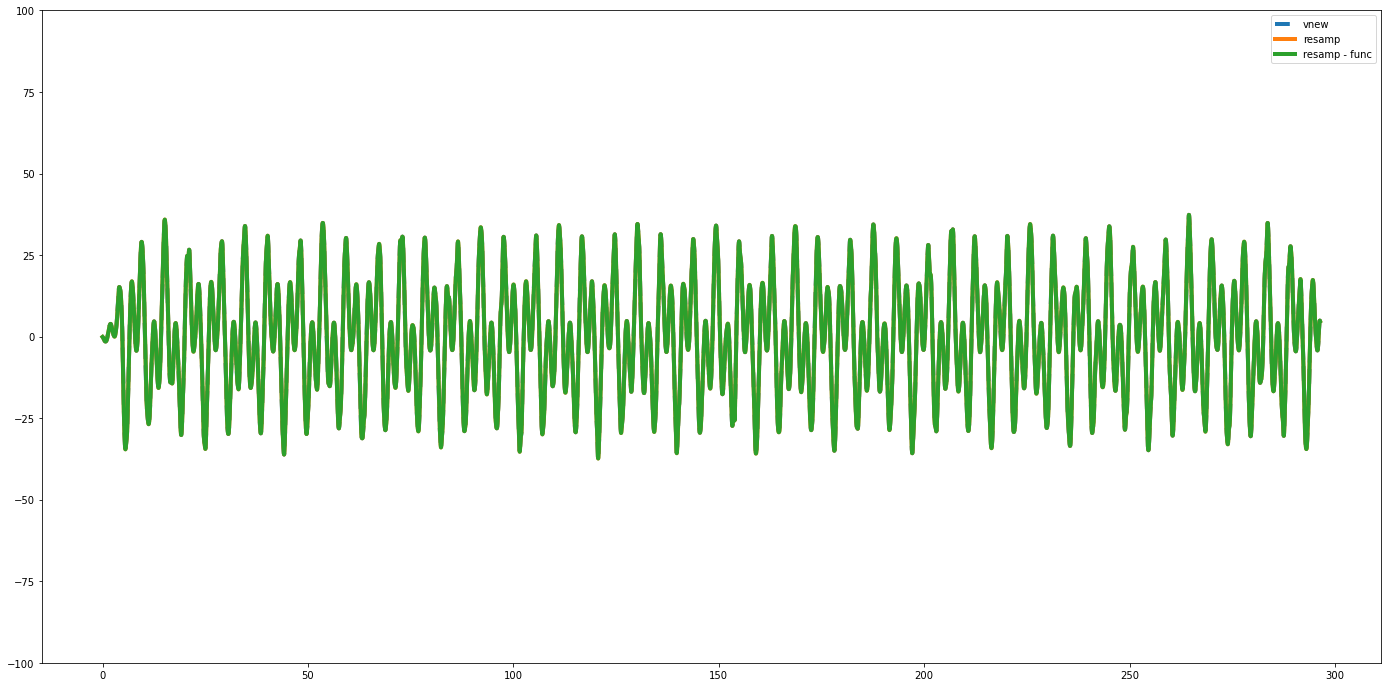

<Figure size 1728x864 with 0 Axes>

In [64]:
# raw
# samsmooth - unf spaced samples and slightly smoother signal
# derivative of samdiff --> butterworth filter, apply filtfilt --> take diff and apply filtfilt to result
# reinterpolate that function to back to labgraph time 

refx = ref[:, 1]
tx = time_x
dec_vel = dec_vels_block1[keys[0]][0, :, 1]
dtx = 1/60
# rearrange the time data so it's evenly sampled for the fft calculations
tnew = np.arange(np.min(tx), np.max(tx), dtx)

# resample the reference with the evenly sampled time
rnew = samsmooth(tnew, tx, refx, 0.1) # smooth and evenly spaced

# take the diff that converts refernce to the velocity
vnew = samdiff(tnew, rnew, 2, 2, 1/dtx)
# vx = np.diff(smooth(refx, kernal_size = 70, mode = 'same'))/np.diff(tx)

# plot the difference
plt.figure(figsize=(24, 12))

# reinterpolate the function back to labgraph time
f = scipy.interpolate.interp1d(tnew[1:], vnew, bounds_error = False, fill_value='extrapolate') # add fill value to last value
vsamp = f(tx[1:])


# confirm that the new function code works
vfunc = diff_vel_from_ref(ref, tx)
assert(np.array_equal(vfunc[1:, 1], vsamp))

# plt.plot(tx[1:], vx, label = 'conv',alpha = 0.5)
plt.plot(tnew[1:], vnew, '--', lw=4, label = "vnew")
plt.plot(tx[1:], vsamp, lw = 4, label = "resamp")
plt.plot(tx[1:], vfunc[1:, 1], lw = 4, label = "resamp - func")

# plt.plot(tx, dec_vel)
plt.legend()
plt.ylim(-100, 100)
plt.figure(figsize=(24, 12))
plt.show()

# difference between function and 





Interpolating the velocity

In [69]:
n_blocks = 2
n_keys = len(keys)
n_conds = 8
n_time = len(times_block1[keys[0]][0])

## add 1s to ref and to int_vels
refs = np.zeros((n_blocks, n_keys, n_conds, n_time, 2))
times = np.zeros((n_blocks, n_keys, n_conds, n_time))
vels = np.zeros_like(refs)

for iK, key in enumerate(keys):
    
    # divide by max of each trial and velocity
    refs[0, iK] = refs_block1[key]
    refs[1, iK] = refs_block2[key]

    times[0, iK] = times_block1[key]
    times[1, iK] = times_block2[key]

In [67]:
# set up vels
vels = np.zeros_like(refs)

In [71]:
# try the time for one subject - time per subj is ~23 seconds

for block in range(n_blocks):
    for subj in range(n_keys):
        print("subj: ", subj)
        for cond in range(n_conds):
            ref_ex = refs[block, subj, cond]
            tx = times[block, subj, cond]
            vfunc = diff_vel_from_ref(ref_ex, tx)

            vels[block, subj, cond] = vfunc


subj:  0
subj:  1
subj:  2
subj:  3
subj:  4
subj:  5
subj:  6
subj:  7
subj:  8
subj:  9
subj:  10
subj:  11
subj:  12
subj:  13
subj:  0
subj:  1
subj:  2
subj:  3
subj:  4
subj:  5
subj:  6
subj:  7
subj:  8
subj:  9
subj:  10
subj:  11
subj:  12
subj:  13


In [72]:
data = [times, refs, vels]

PATH = '/Users/mmadduri/Documents/GitHub/meta-analysis/'
with open(PATH + 'ref_vel_data.pickle','wb') as handle:
    pickle.dump(data,handle,protocol=pickle.HIGHEST_PROTOCOL)